# Brain-Tumor-Classification-Segmentation

## Import Libraries

In [42]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Load and Preprocess Images and Masks

In [33]:
zip_path = "brian tumer segmention.zip"   

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_dataset")
    
subfolders = list(Path("brain_tumor_dataset").glob("*"))
dataset_path = subfolders[0]
print(f"Dataset root folder detected: {dataset_path}")

Dataset root folder detected: brain_tumor_dataset\kaggle_3m


In [38]:
images = []
masks = []
all_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
for folder in all_folders:
    folder_path = os.path.join(dataset_path, folder)
    files = sorted(os.listdir(folder_path))
    for f in files:
        if "mask" in f.lower():
            mask_path = os.path.join(folder_path, f)
            image_name = f.replace('_mask', '')
            image_path = os.path.join(folder_path, image_name)

            if os.path.exists(image_path):
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                if img is not None and mask is not None:
                    img = cv2.resize(img, (128, 128)) / 255.0
                    mask = cv2.resize(mask, (128, 128)) / 255.0

                    images.append(img[..., np.newaxis])
                    masks.append(mask[..., np.newaxis])

X = np.array(images)
y = np.array(masks)

## Split Train-Validation

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Total folders:", len(all_folders))
print("Total images loaded:", len(images))
print("Total masks loaded:", len(masks))
print("Shape of image dataset (X):", X.shape)
print("Shape of mask dataset (y):", y.shape)
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Total folders: 110
Total images loaded: 3929
Total masks loaded: 3929
Shape of image dataset (X): (3929, 128, 128, 1)
Shape of mask dataset (y): (3929, 128, 128, 1)
Train set shape: (3143, 128, 128, 1) (3143, 128, 128, 1)
Validation set shape: (786, 128, 128, 1) (786, 128, 128, 1)


## Random Samples

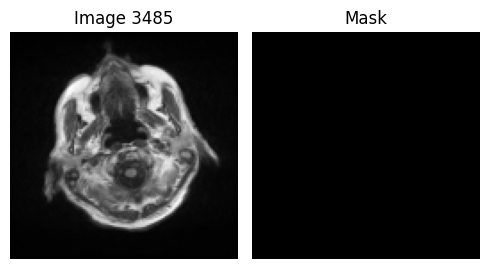

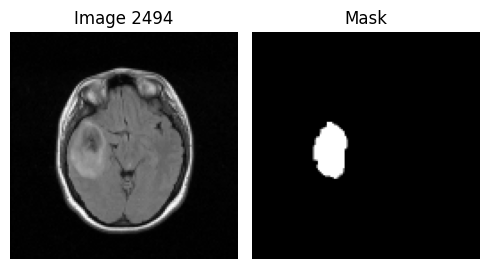

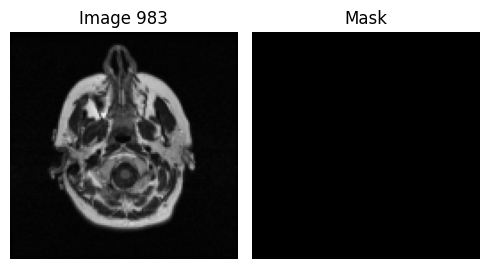

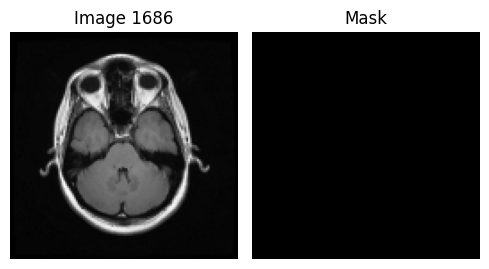

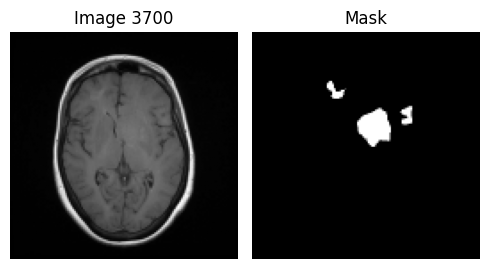

In [48]:
def show_sample(index):
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X[index].squeeze(), cmap='gray')
    plt.title(f"Image {index}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(y[index].squeeze(), cmap='gray')
    plt.title("Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

random_indices = random.sample(range(len(X)), 5)
for idx in random_indices:
    show_sample(idx)

##  U-Net Model

In [50]:
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    p3 = MaxPooling2D()(c3)

    b = Conv2D(128, 3, activation='relu', padding='same')(p3)

    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c3])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(u1)

    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(32, 3, activation='relu', padding='same')(u2)

    u3 = Conv2DTranspose(16, 2, strides=2, padding='same')(c5)
    u3 = concatenate([u3, c1])
    c6 = Conv2D(16, 3, activation='relu', padding='same')(u3)

    outputs = Conv2D(1, 1, activation='sigmoid')(c6)

    model = Model(inputs, outputs)
    return model

## Compile and Train the Model

In [52]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=10
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 16)      │             160 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 16)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 64, 64, 32)        │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 32)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 16, 64)        │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 32, 32, 64)        │          32,832 │ conv2d_3[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 32, 32, 128)       │               0 │ conv2d_transpose[0][0],    │
│                               │                           │                 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 64)        │          73,792 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_1            │ (None, 64, 64, 32)        │           8,224 │ conv2d_4[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 64, 64, 64)        │               0 │ conv2d_transpose_1[0][0],  │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 32)        │          18,464 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 237,169 (926.44 KB)

 Trainable params: 237,169 (926.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 102s 490ms/step - accuracy: 0.9888 - loss: 0.0832 - val_accuracy: 0.9890 - val_loss: 0.0448
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 138s 471ms/step - accuracy: 0.9889 - loss: 0.0378 - val_accuracy: 0.9890 - val_loss: 0.0369
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 148s 502ms/step - accuracy: 0.9889 - loss: 0.0360 - val_accuracy: 0.9890 - val_loss: 0.0352
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 102s 517ms/step - accuracy: 0.9891 - loss: 0.0351 - val_accuracy: 0.9859 - val_loss: 0.0448
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 135s 482ms/step - accuracy: 0.9890 - loss: 0.0348 - val_accuracy: 0.9896 - val_loss: 0.0351
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 94s 476ms/step - accuracy: 0.9895 - loss: 0.0337 - val_accuracy: 0.9897 - val_loss: 0.0330
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 144s 486ms/step - accuracy: 0.9899 - loss: 0.0326 - val_accuracy: 0.9890 - val_loss: 0.0363
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 140s 476ms/step - accuracy: 0.9899 - 

## Display Model Forecasts on the Validation Set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


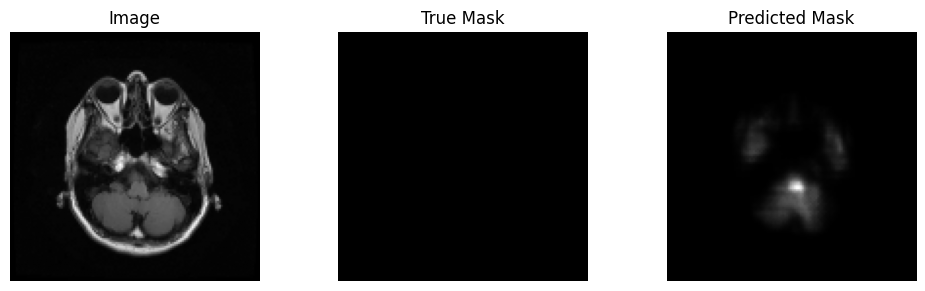

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


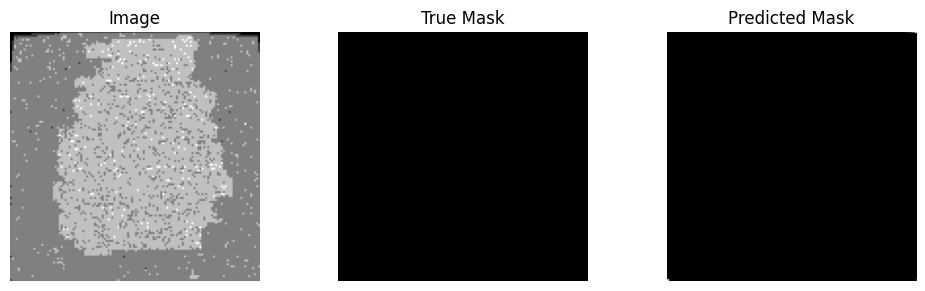

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


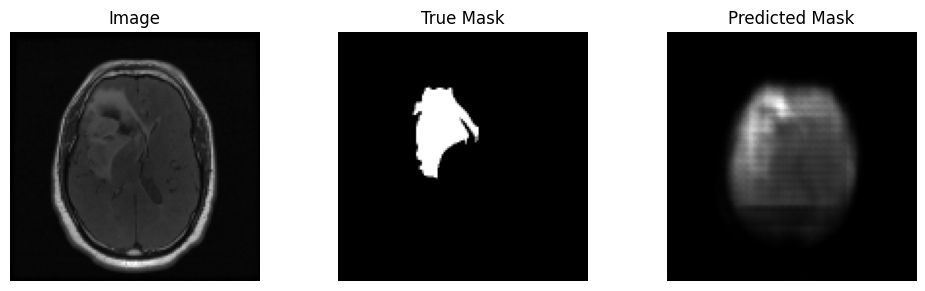

In [54]:
def show_prediction(index):
    img = X_val[index]
    true_mask = y_val[index]
    pred_mask = model.predict(img[np.newaxis, ...])[0]

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

for i in range(3):
    show_prediction(i)

## Identify New Test Images

Found 46 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


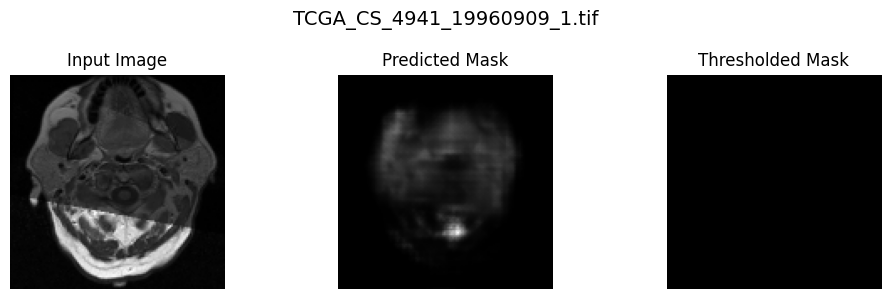

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


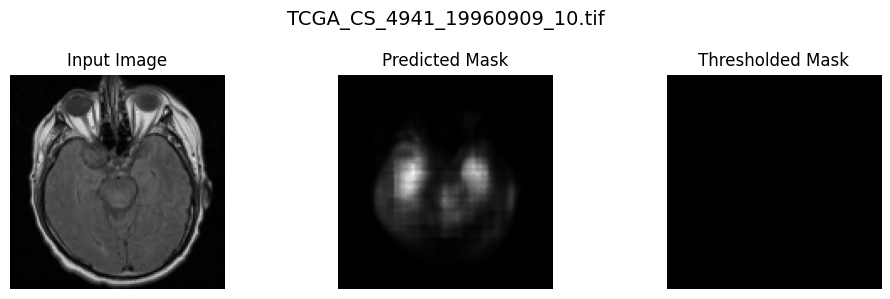

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


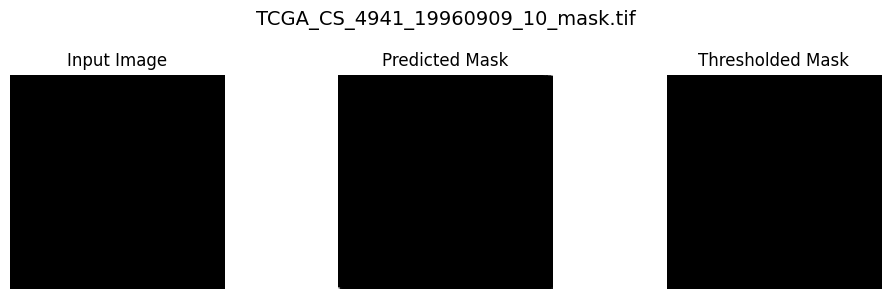

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


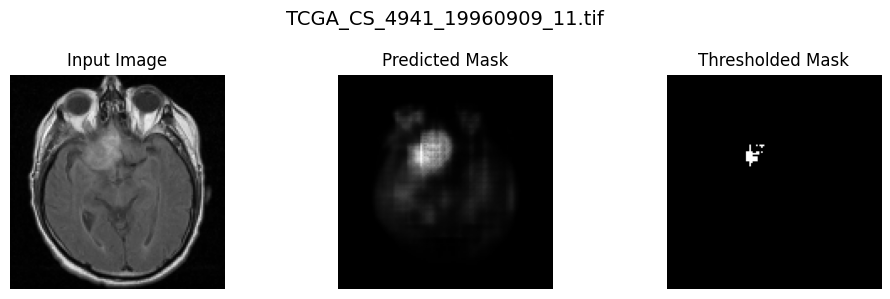

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


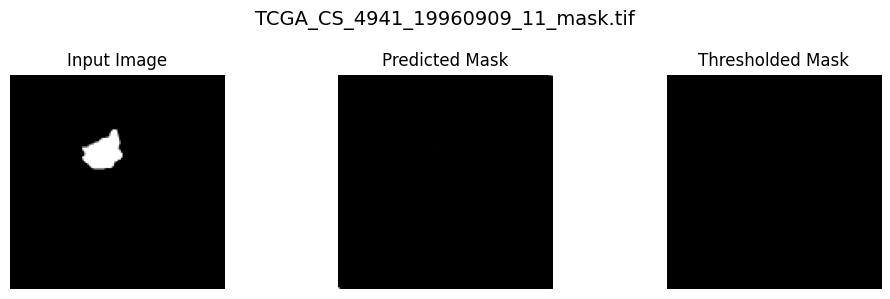

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


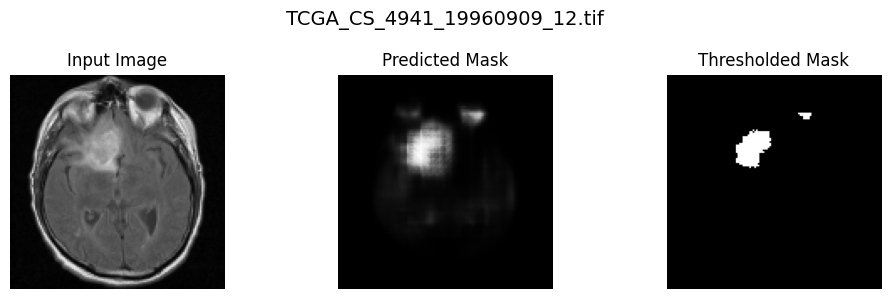

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


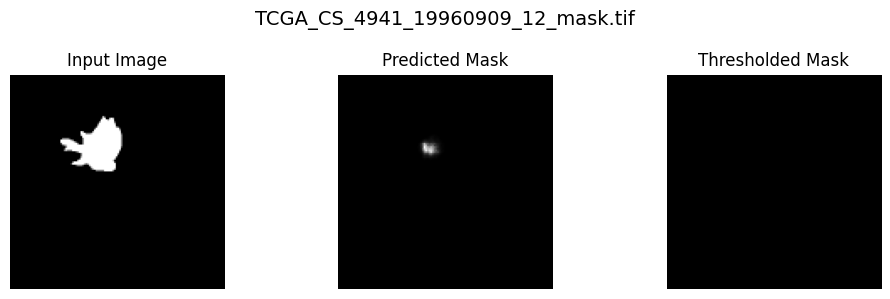

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


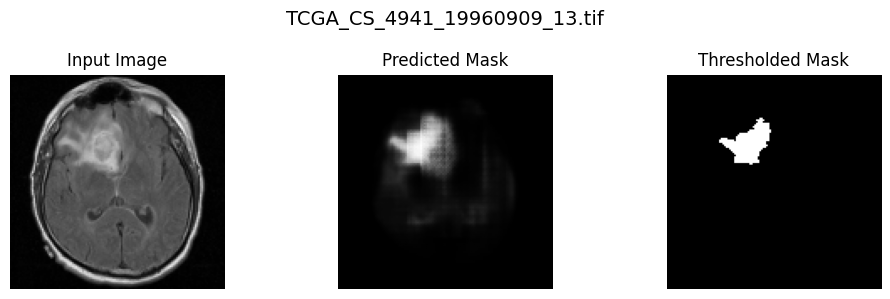

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


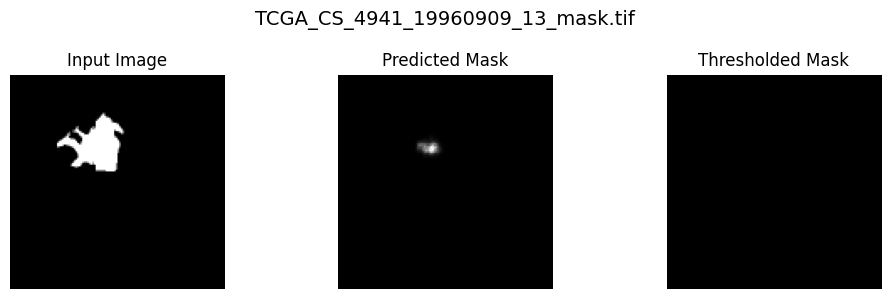

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


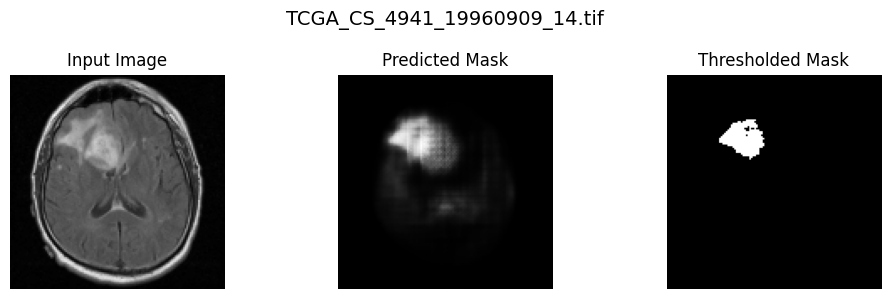

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


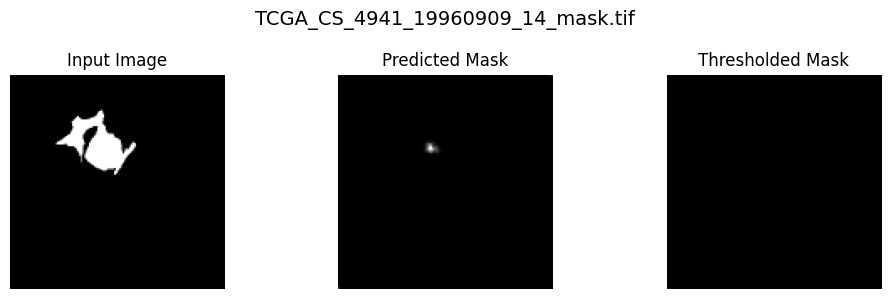

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


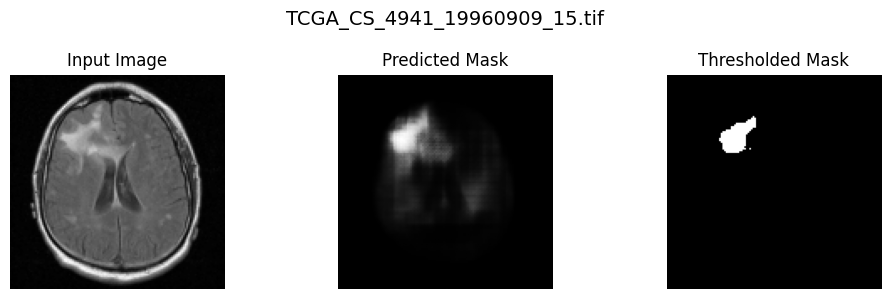

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


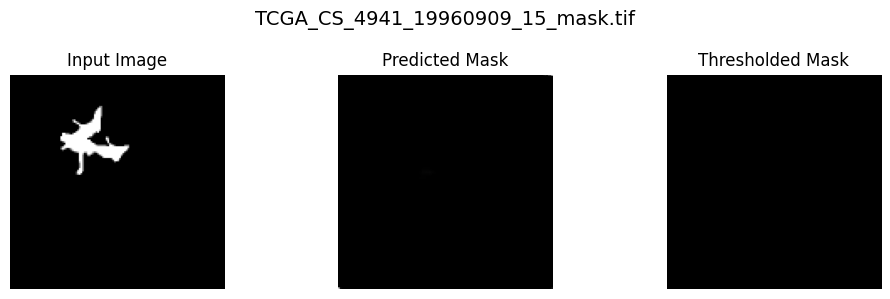

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


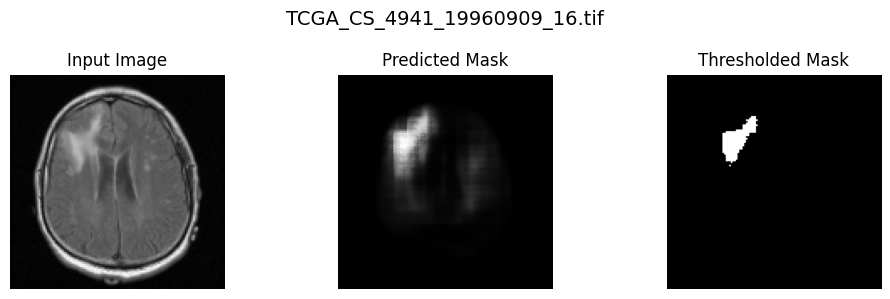

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


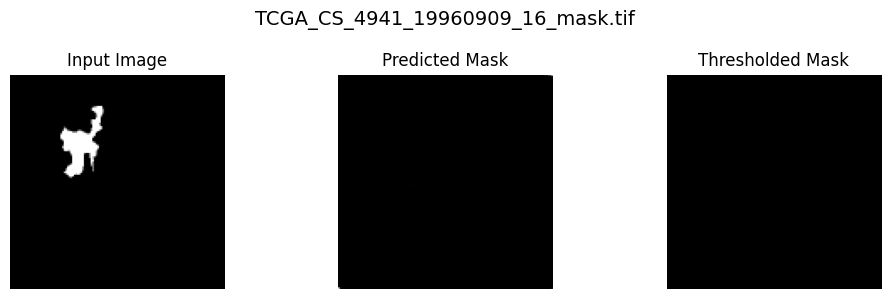

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


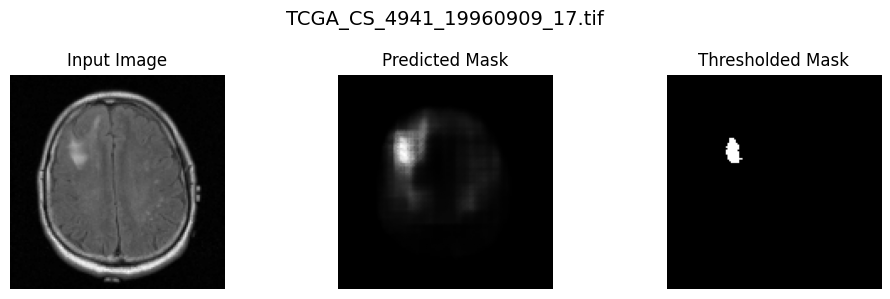

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


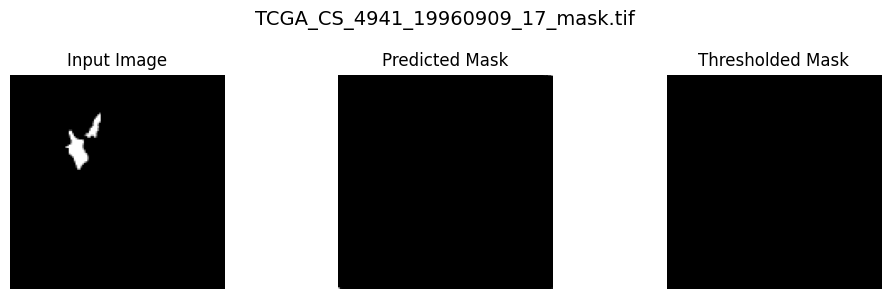

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


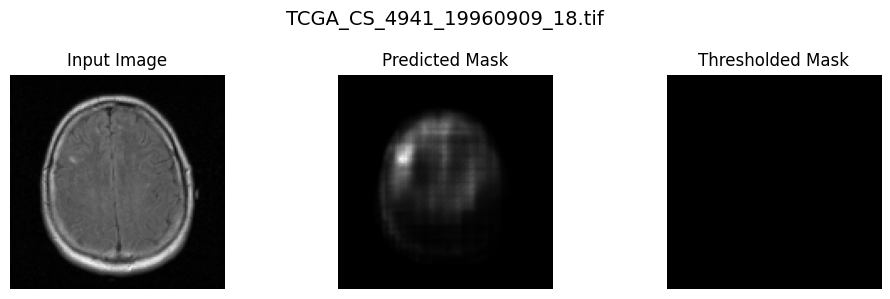

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


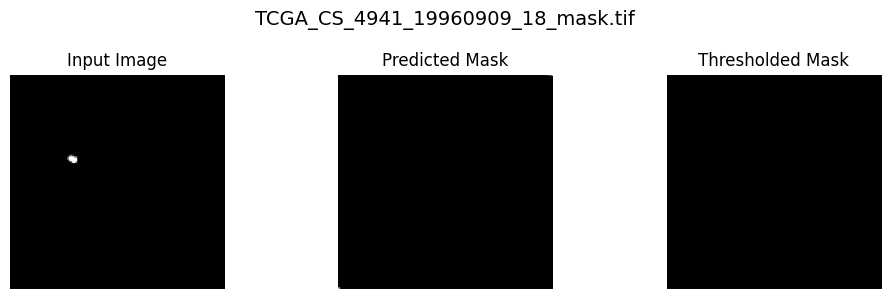

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


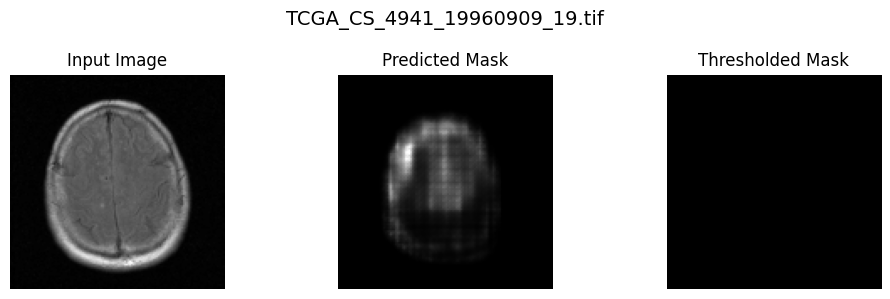

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


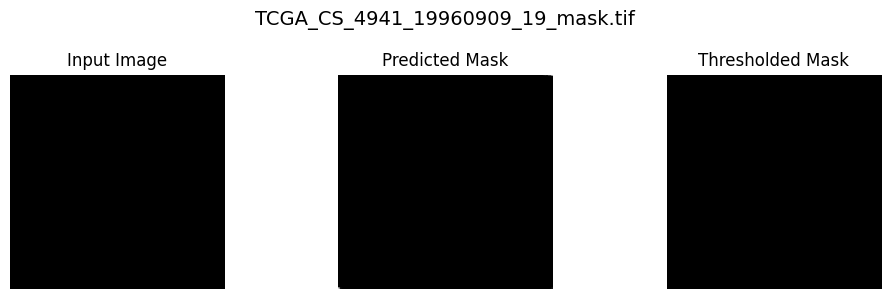

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


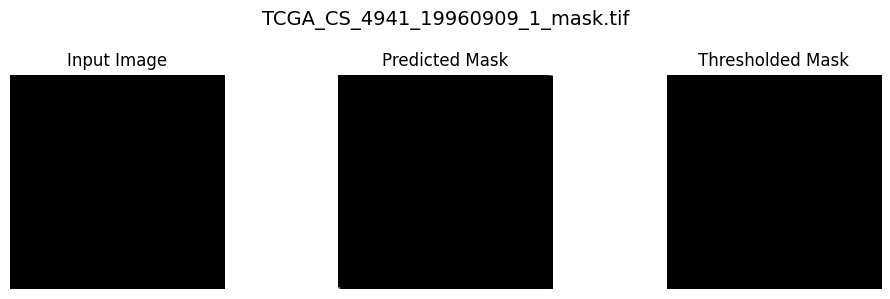

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


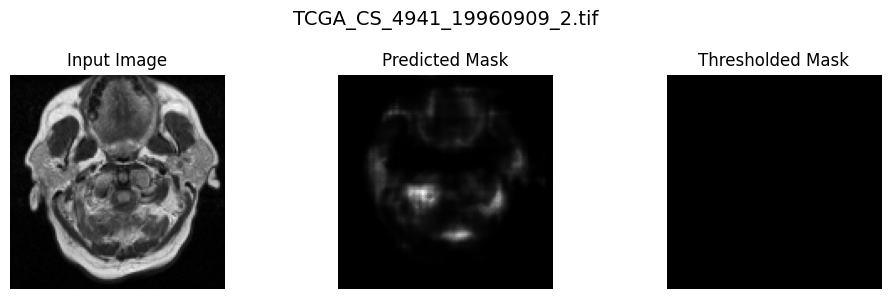

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


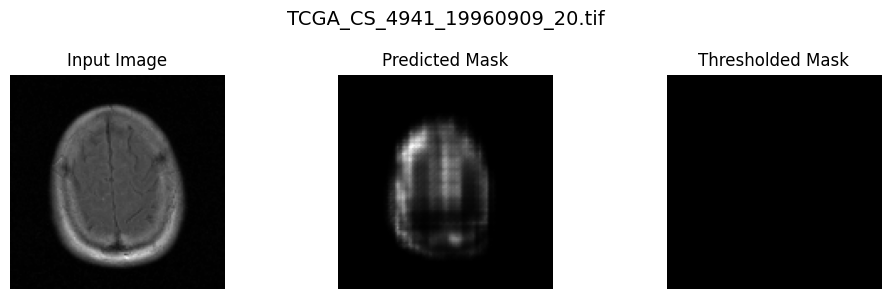

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


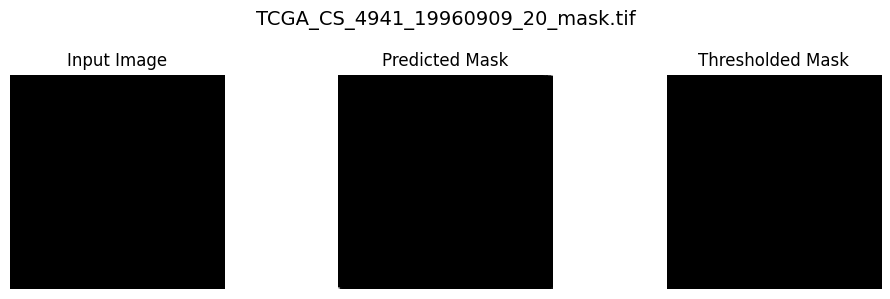

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


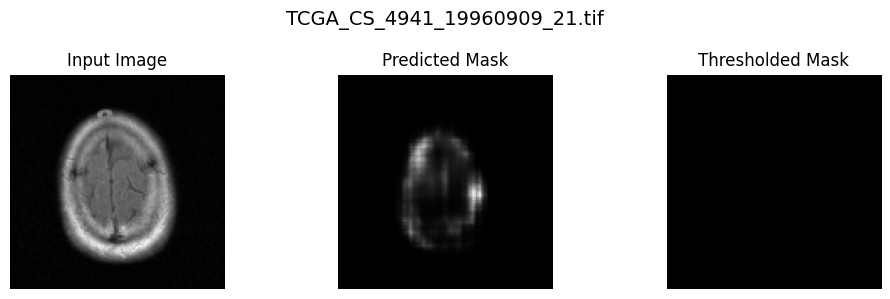

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


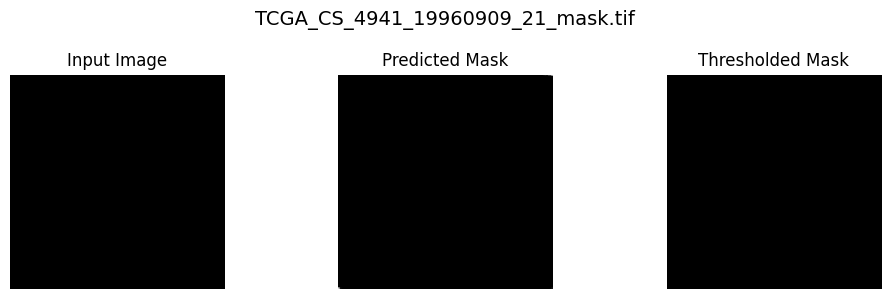

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


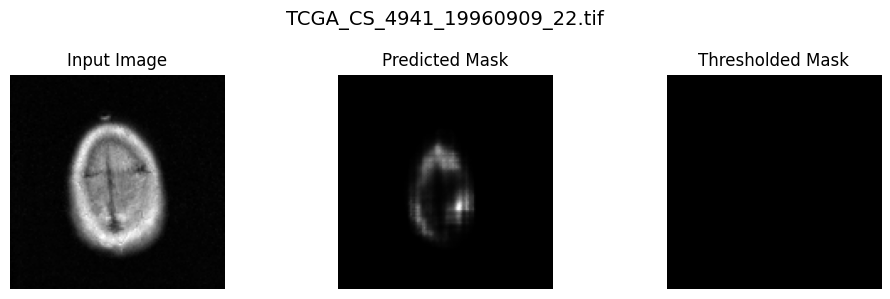

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


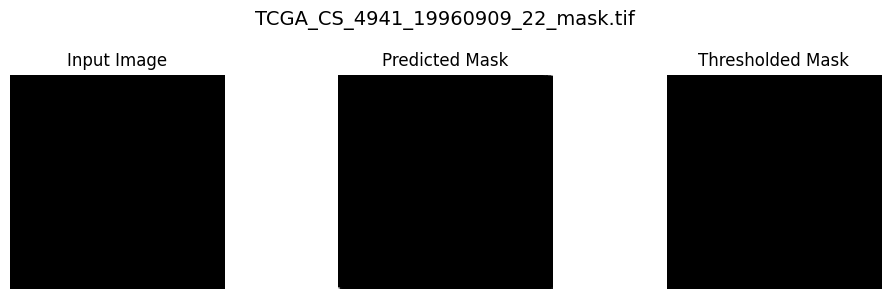

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


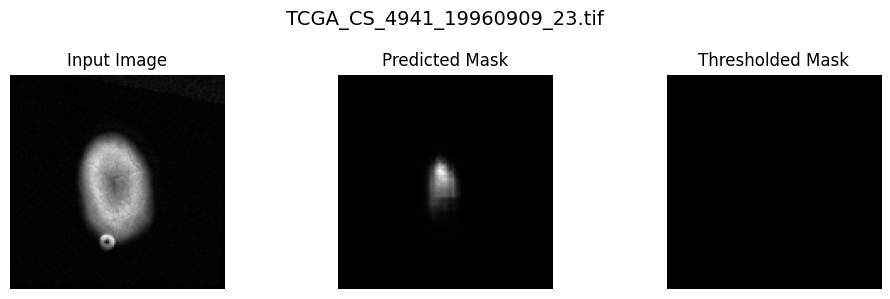

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


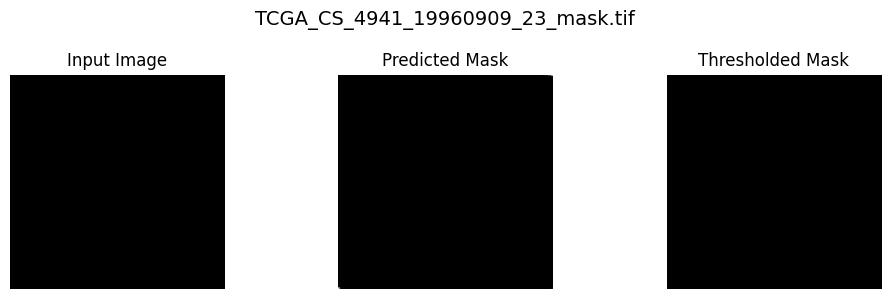

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


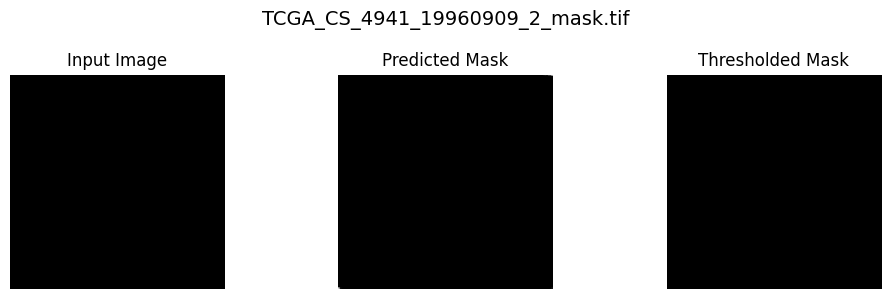

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


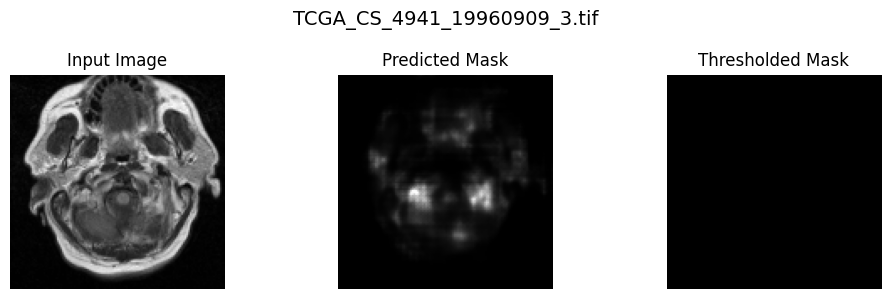

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


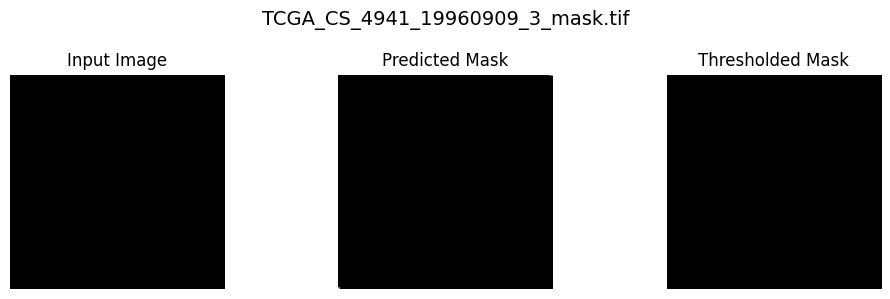

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


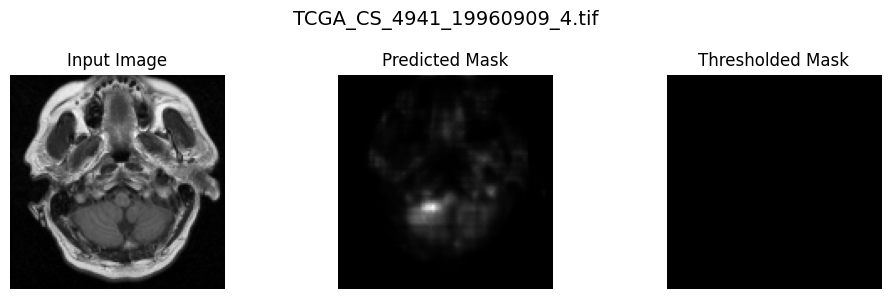

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


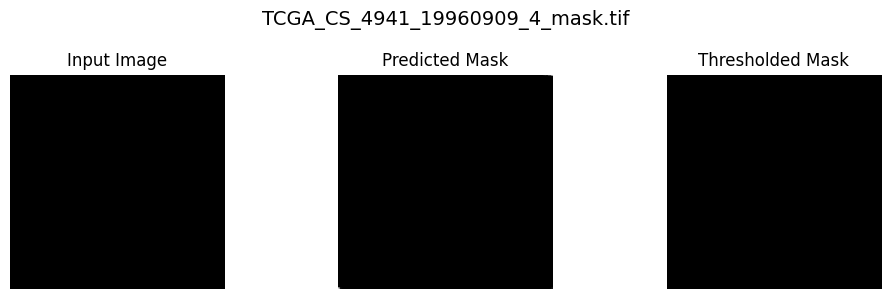

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


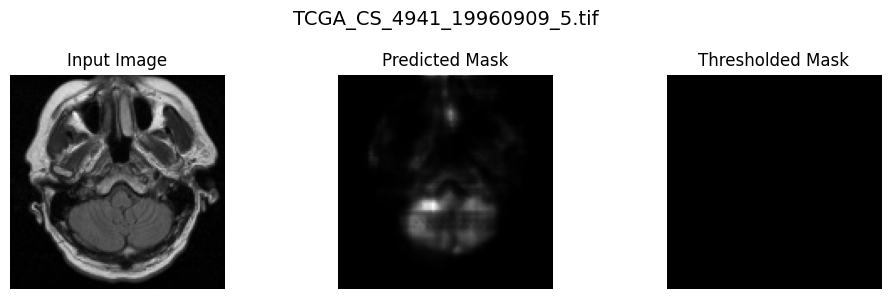

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


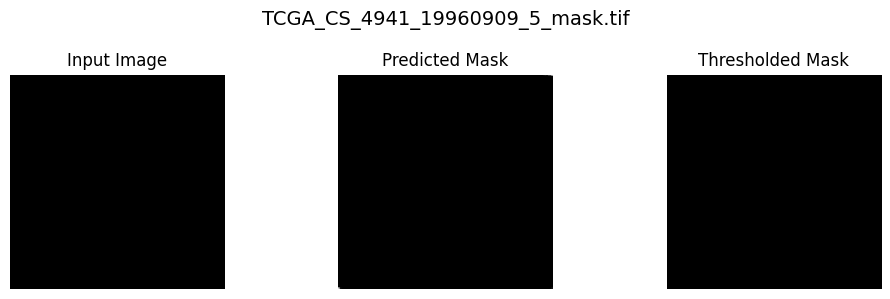

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


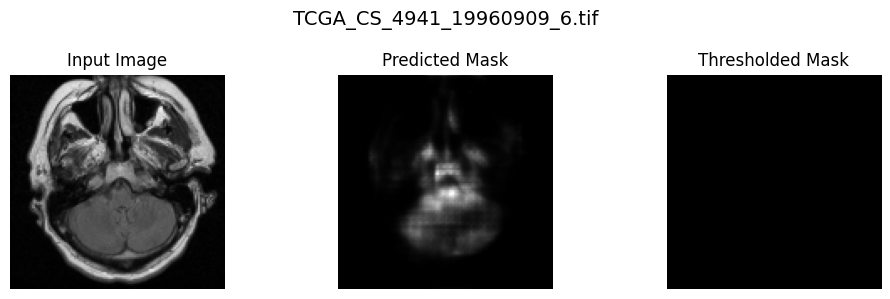

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


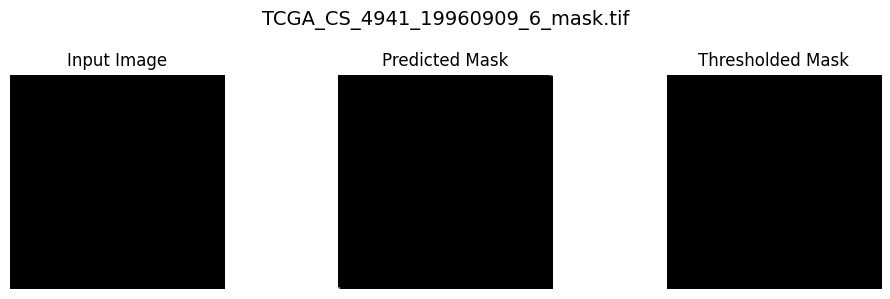

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


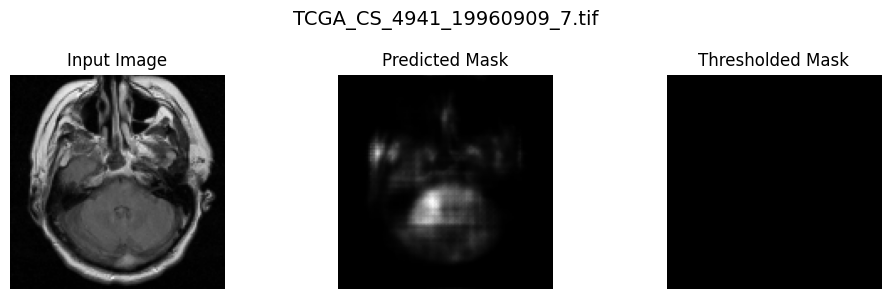

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


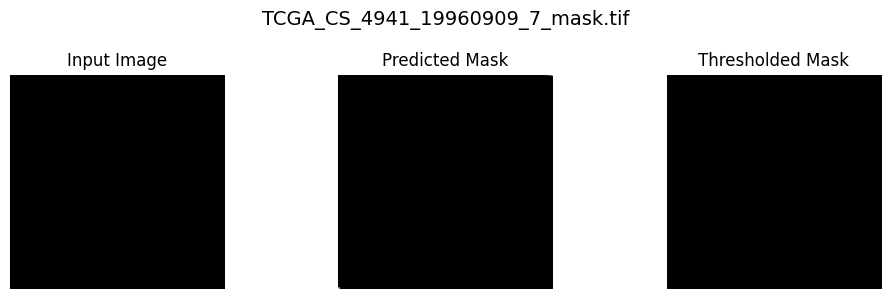

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


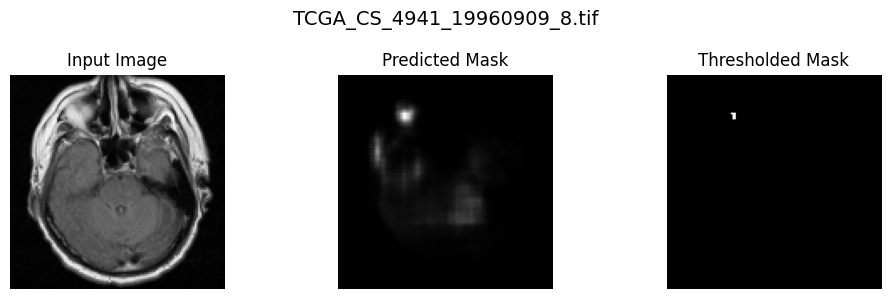

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


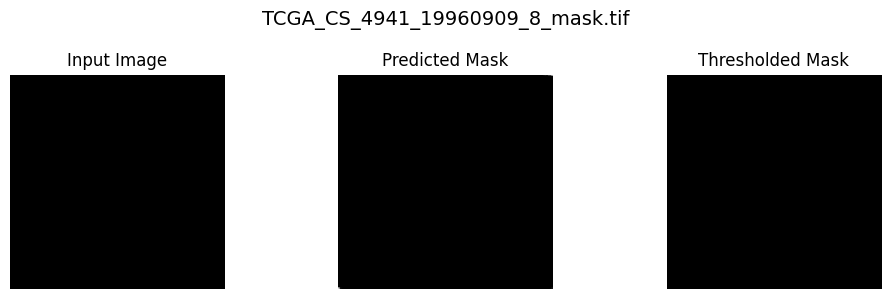

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


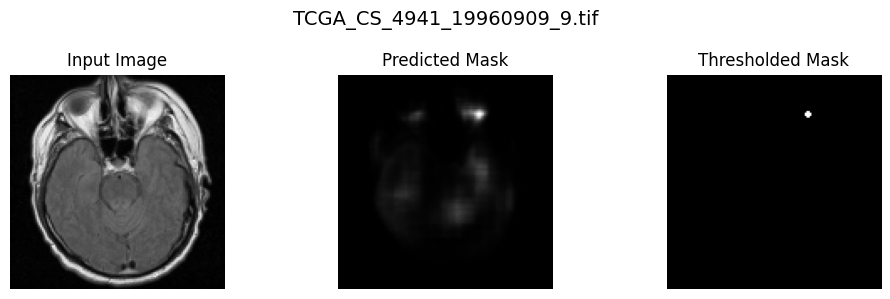

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


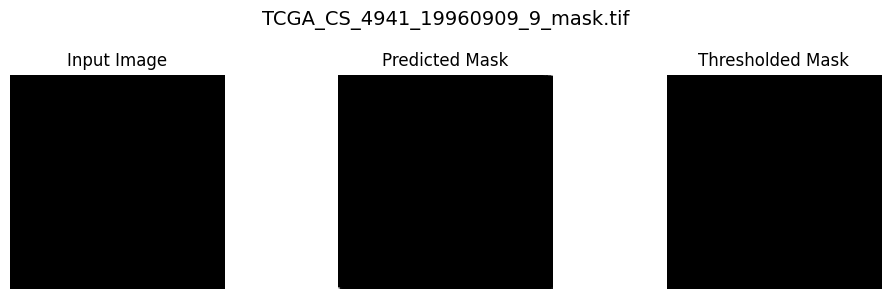

In [67]:
test_zip = "brain tumer segmintion test.zip"
extract_dir = "brain_tumor_dataset_test"

with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

image_files = list(Path(extract_dir).rglob("*.[jp][pn]g")) + \
              list(Path(extract_dir).rglob("*.jpeg")) + \
              list(Path(extract_dir).rglob("*.bmp")) + \
              list(Path(extract_dir).rglob("*.tif")) + \
              list(Path(extract_dir).rglob("*.tiff"))

print(f"Found {len(image_files)} test images.")

for img_path in image_files:
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    img_resized = cv2.resize(img, (128, 128)) / 255.0
    img_input = img_resized[np.newaxis, ..., np.newaxis]

    pred_mask = model.predict(img_input)[0]
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(10, 3))
    plt.suptitle(f"{img_path.name}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_binary.squeeze(), cmap='gray')
    plt.title("Thresholded Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()